In [6]:

import numpy as np

S= 100 #Initial Price
r= 0.05 #Risk-free Rate
sig= 0.2 #Volatility
T= 1  #Maturity
M= 50#Time Steps 
N= 100000  #No of Paths


def gen_gbm_paths(S,r,sig,T,N,M):
    
    dt = T/M
    drift= (r-0.5*sig**2)*dt
    diff= sig* np.sqrt(dt)
    
    paths= np.zeros((N,M+1))
    paths[:,0]=S
    
    for t in range(1,M+1): 
        z= np.random.normal(0,1,N)
        paths[:,t]= paths[:,t-1]* np.exp(drift + diff*z)
    
    return paths 

def price_arithavg_floatinstrike(S,r,sig,T,M,N):
    
    paths = gen_gbm_paths(S, r, sig, T, N, M)
    ST= paths[:,-1] #price at expiry for all N
    avg = np.mean(paths[:,1:] , axis=1) #average of all rows and all col excluding 1st
    payoffs = np.maximum(ST-avg, 0) #payoff for asian call
    
    discounted= payoffs * np.exp(-r*T)
    price = np.mean(discounted)
    sd= np.std(discounted, ddof=1)/np.sqrt(N)
    
    return price, sd
    
def price_arithavg_fixedstrike(S, r, sig, T, M, K, N):
    paths = gen_gbm_paths(S, r, sig, T, N, M)
    avg = np.mean(paths[:, 1:], axis=1)  # exclude S0
    payoffs = np.maximum(avg - K, 0)     # <-- Fixed strike payoff

    discounted = payoffs * np.exp(-r * T)
    price = np.mean(discounted)
    sd = np.std(discounted, ddof=1) / np.sqrt(N)

    return price, sd

# CI = price + 1.96 *sd at 95%

price, sd = price_arithavg_floatinstrike(S, r, sig, T, M, N)

print(price,"and", sd)
    
    

5.78674559112667 and 0.02649798512098076


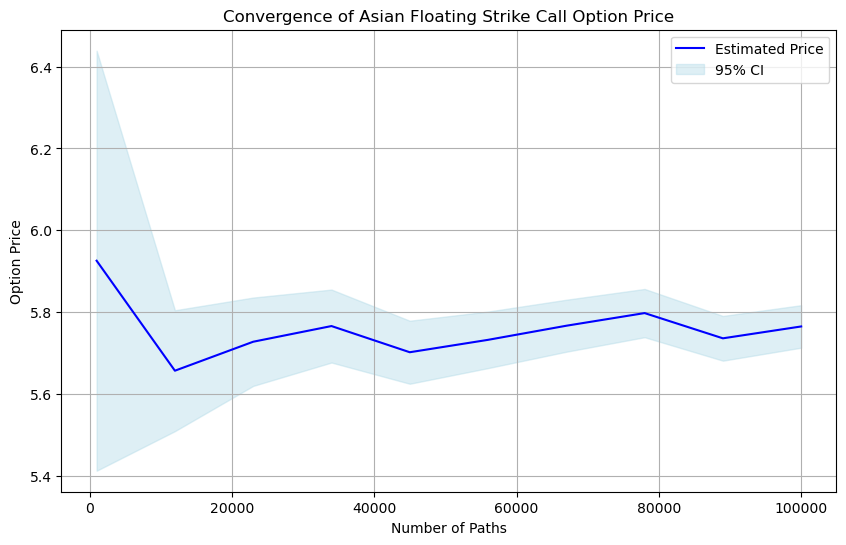

In [2]:
import matplotlib.pyplot as plt

def convergence_plot(S, r, sig, T, M, path_range):
    prices = []
    errors = []

    for N in path_range:
        price, sd = price_arithavg_floatinstrike(S, r, sig, T, M, N)
        prices.append(price)
        errors.append(sd)
    
    plt.figure(figsize=(10,6))
    plt.plot(path_range, prices, label='Estimated Price', color='blue')
    plt.fill_between(path_range, 
                     np.array(prices) - 1.96*np.array(errors), 
                     np.array(prices) + 1.96*np.array(errors), 
                     color='lightblue', alpha=0.4, label='95% CI')
    plt.xlabel("Number of Paths")
    plt.ylabel("Option Price")
    plt.title("Convergence of Asian Floating Strike Call Option Price")
    plt.legend()
    plt.grid(True)
    plt.show()

path_range = np.linspace(1000, 100000, 10, dtype=int)
convergence_plot(S, r, sig, T, M, path_range)


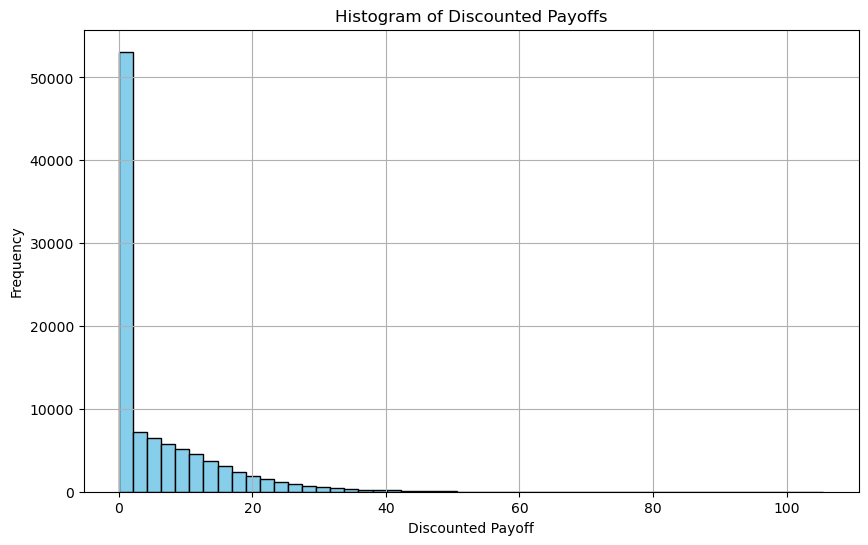

In [3]:
def payoff_histogram(S, r, sig, T, M, N):
    paths = gen_gbm_paths(S, r, sig, T, N, M)
    ST = paths[:, -1]
    avg = np.mean(paths[:, 1:], axis=1)
    payoffs = np.maximum(ST - avg, 0)
    discounted = payoffs * np.exp(-r * T)

    plt.figure(figsize=(10,6))
    plt.hist(discounted, bins=50, color='skyblue', edgecolor='black')
    plt.title("Histogram of Discounted Payoffs")
    plt.xlabel("Discounted Payoff")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

payoff_histogram(S, r, sig, T, M, 100000)


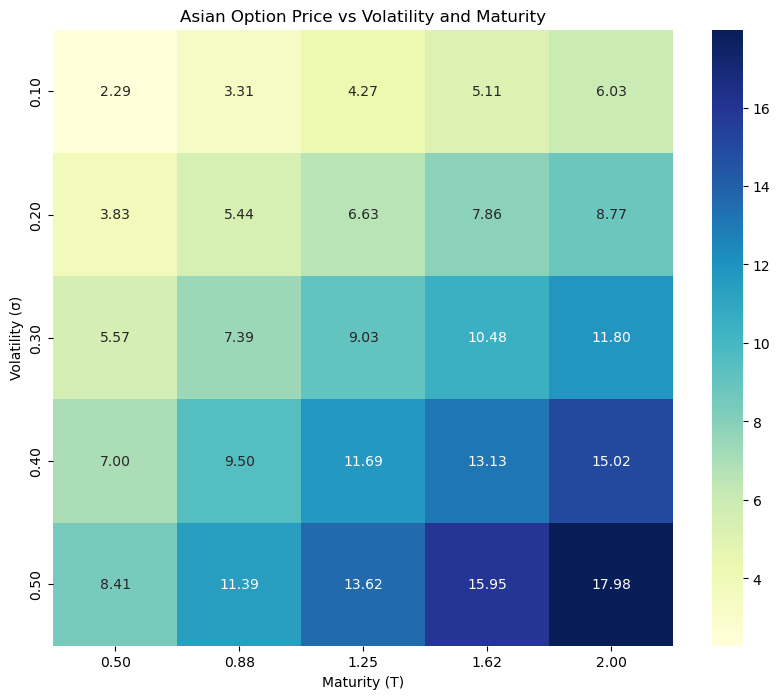

In [4]:
import seaborn as sns
import pandas as pd

def heatmap_vol_t(S, r, vol_range, T_range, M, N):
    data = []

    for sigma in vol_range:
        row = []
        for T_val in T_range:
            price, _ = price_arithavg_floatinstrike(S, r, sigma, T_val, M, N)
            row.append(price)
        data.append(row)

    df = pd.DataFrame(data, index=[f"{v:.2f}" for v in vol_range], columns=[f"{t:.2f}" for t in T_range])

    plt.figure(figsize=(10,8))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Asian Option Price vs Volatility and Maturity")
    plt.xlabel("Maturity (T)")
    plt.ylabel("Volatility (σ)")
    plt.show()

vol_range = np.linspace(0.1, 0.5, 5)
T_range = np.linspace(0.5, 2, 5)
heatmap_vol_t(S, r, vol_range, T_range, M=50, N=10000)


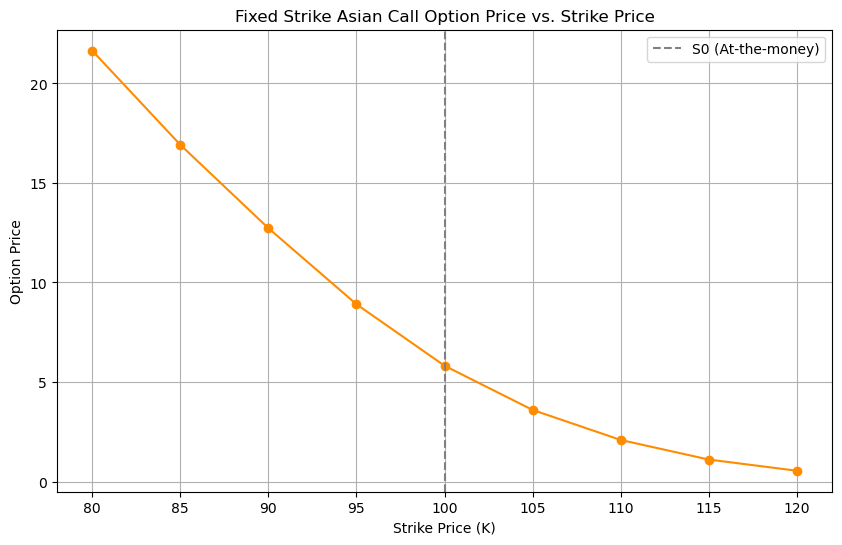

In [7]:
import matplotlib.pyplot as plt

def plot_price_vs_strike(S, r, sig, T, M, N, K_range):
    prices = []

    for K in K_range:
        price, _ = price_arithavg_fixedstrike(S, r, sig, T, M, K, N)
        prices.append(price)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, prices, marker='o', linestyle='-', color='darkorange')
    plt.title("Fixed Strike Asian Call Option Price vs. Strike Price")
    plt.xlabel("Strike Price (K)")
    plt.ylabel("Option Price")
    plt.grid(True)
    plt.axvline(S, color='gray', linestyle='--', label='S0 (At-the-money)')
    plt.legend()
    plt.show()

K_range = np.arange(80, 121, 5)  # Test from K=80 to 120
plot_price_vs_strike(S=100, r=0.05, sig=0.2, T=1, M=50, N=50000, K_range=K_range)


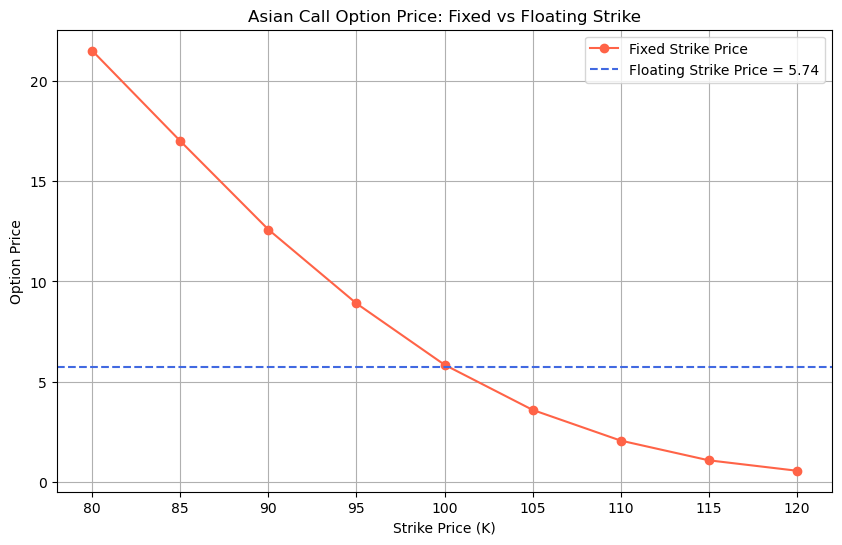

In [8]:
def compare_fixed_vs_floating_vs_strike(S, r, sig, T, M, N, K_range):
    fixed_prices = []
    
    # Compute floating strike price once (independent of K)
    floating_price, _ = price_arithavg_floatinstrike(S, r, sig, T, M, N)

    for K in K_range:
        price, _ = price_arithavg_fixedstrike(S, r, sig, T, M, K, N)
        fixed_prices.append(price)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, fixed_prices, label="Fixed Strike Price", marker='o', color='tomato')
    plt.axhline(y=floating_price, color='royalblue', linestyle='--', label=f"Floating Strike Price = {floating_price:.2f}")
    plt.xlabel("Strike Price (K)")
    plt.ylabel("Option Price")
    plt.title("Asian Call Option Price: Fixed vs Floating Strike")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
K_range = np.arange(80, 121, 5)
compare_fixed_vs_floating_vs_strike(S=100, r=0.05, sig=0.2, T=1, M=50, N=50000, K_range=K_range)
